# Survey Validation Data Challenge - Summer 2018

### Notebook 2 -- Tile the BGS/GAMA Fields and run survey simulations

The purpose of this notebook is to construct a set of DESI tiles (pointings) for each of the GAMA/BGS fields and to simulate observations of just the G02 field.

In [1]:
import os, time
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

In [2]:
import fitsio

In [3]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, palette='Set2')

In [4]:
%matplotlib inline

In [5]:
print("Starting at {}".format(time.asctime()))
notebook_start_time = time.time()

Starting at Tue Jun 19 09:32:18 2018


### Define the top-level base (output) directory.

In [6]:
basedir = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', 'svdc-summer2018')
samplefile = os.path.join(basedir, 'bgs-gama-sample.fits')
tilesfile = os.path.join(basedir, 'bgs-gama-tiles.fits')
surveyconfigfile = os.path.join(basedir, 'sv-bgs-survey-config.yaml')

#### Specify whether the output catalog should be overwritten.

If *overwrite_tiles=True* all the output files and plots will be recreated.

In [21]:
overwrite_tiles = True
overwrite_surveysim = True

### Read the parent sample of GAMA targets.
This parent sample was written by the *bgs-gama-sample.ipynb* notebook.

In [8]:
def read_sample():
    if os.path.isfile(samplefile):
        gama = Table(fitsio.read(samplefile, ext=1))
        print('Read {} objects from {}'.format(len(gama), samplefile))
    else:
        print('Sample file {} not found!'.format(samplefile))
        gama = []
    return gama

In [9]:
gama = read_sample()

Read 124683 objects from /Users/ioannis/work/desi/datachallenge/svdc-summer2018/bgs-gama-sample.fits


### Tile the G02, G09, G12, and G15 GAMA fields.

As an initial effort, we tile each of the GAMA fields very simplistically, using constant offsets in RA and Dec.  The next iteration of this notebook will need to consider the dither pattern required to fill in the gaps in the DESI focal plane due to the central bullseye (0.2 deg) and the GFA gaps (0.4 deg).

In [10]:
def simple_radec_off_scheme(ras, decs, dx=0.6, ang=42):
    """Code written by E. Schlafly (LBNL).
    
    Take a single covering and define four sets of offsets, starting with something 
    minimal. 
    
    Need to cover central bulls-eyes (0.2 deg) and GFA gaps (p to 0.4 deg).

    """
    ang = np.radians(ang)
    dang = np.pi/2
    dithers = [[0, 0], 
               [dx*np.sin(ang+0*dang), dx*np.cos(ang+0*dang)], 
               [dx*np.sin(ang+1*dang), dx*np.cos(ang+1*dang)],
               [dx*np.sin(ang+2*dang), dx*np.cos(ang+2*dang)]]
    dithers = np.cumsum(np.array(dithers), axis=0)
    dithers = list(dithers) + [[np.mean([d[0] for d in dithers]),
                                np.mean([d[1] for d in dithers])]]
    fac = 1./np.cos(np.radians(decs))
    fac = np.clip(fac, 1, 360*5)  # confusion near celestial pole.
    newras = np.concatenate([ras+d[0]*fac for d in dithers])
    newdecs = np.concatenate([decs+d[1] for d in dithers])
    newdecs = np.clip(newdecs, -np.inf, 90.)
    newras = newras % 360
    newras = np.concatenate([newras, newras])
    newdecs = np.concatenate([newdecs, newdecs])
    
    return newras, newdecs

In [11]:
def radec2tiles(ra, dec, tileid_start=100000, overwrite=False):
    """Given an input set of tile coordinates (centers), return a 
    table of tiles.
    
    """
    from astropy.table import Table, Column
    
    ntile = len(np.atleast_1d(ra))
    
    tiles = Table()
    tiles.add_column(Column(name='TILEID', dtype=np.int32, length=ntile))
    tiles.add_column(Column(name='RA', dtype='f8', length=ntile))
    tiles.add_column(Column(name='DEC', dtype='f8', length=ntile))
    tiles.add_column(Column(name='PASS', dtype=np.int16, length=ntile))
    tiles.add_column(Column(name='IN_DESI', dtype=np.int16, length=ntile))
    tiles.add_column(Column(name='EBV_MED', dtype='f4', length=ntile))
    tiles.add_column(Column(name='AIRMASS', dtype='f4', length=ntile))
    tiles.add_column(Column(name='STAR_DENSITY', dtype='f4', length=ntile))
    tiles.add_column(Column(name='EXPOSEFAC', dtype='f4', length=ntile))
    tiles.add_column(Column(name='PROGRAM', dtype='S4', length=ntile))
    tiles.add_column(Column(name='OBSCONDITIONS', dtype=np.int32, length=ntile))
    
    tiles['RA'] = ra
    tiles['DEC'] = dec
    tiles['TILEID'] = np.arange(ntile) + tileid_start
    tiles['PASS'] = 1          # ??
    tiles['AIRMASS'] = 1.0     # to be filled in by surveysim
    tiles['IN_DESI'] = 1       # assume all "in DESI"
    tiles['EXPOSEFAC'] = 1.0   # ??
    tiles['PROGRAM'] = 'DARK'
    tiles['OBSCONDITIONS'] = 1 # ??
    
    if overwrite:
        print('Writing {}'.format(tilesfile))
        tiles.write(tilesfile, overwrite=overwrite)
    
    return tiles

In [12]:
def plot_tile(ra, dec, r=1.606, color='k', ax=None):
    '''Approximate plot of tile location'''
    ang = np.linspace(0, 2*np.pi, 100)
    x = ra + r*np.cos(ang)/np.cos(np.radians(dec))
    y = dec + r*np.sin(ang)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(x,y, '-', color=color, alpha=0.5)

In [13]:
def qa_gama_tiles(gama, tiles, overwrite=False):
    
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax = ax.reshape(4)
    
    for thisax, field in zip(ax, sorted(set(gama['FIELD']))):
        
        infield = gama['FIELD'] == field
    
        thisax.scatter(gama['RA'][infield], gama['DEC'][infield], 
                       s=1, alpha=0.5, marker='s')
        
        ww = ( (tiles['RA'] > gama['RA'][infield].min()) * (tiles['RA'] < gama['RA'][infield].max()) * 
               (tiles['DEC'] > gama['DEC'][infield].min()) * (tiles['DEC'] < gama['DEC'][infield].max()) )
        for tt in tiles[ww]:
            plot_tile(tt['RA'], tt['DEC'], ax=thisax)
            
        thisax.set_xlabel('RA')
        thisax.set_ylabel('Dec')
        thisax.invert_xaxis()
        thisax.set_title(field)
    
    fig.tight_layout()
    if overwrite:
        pngfile = os.path.join(basedir, 'qaplots', 'qa-gama-tiles.png')
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile)    

In [14]:
def gama_tiles(gama, radius=1.6, debug=False, overwrite=False):
    """Tile each of the GAMA fields."""
    
    gama_radec = { # Field corners
        'G02': (30.2, 38.8, -6, -4),
        'G09': (129, 141, -2, 3),
        'G12': (174, 186, -3, 2),
        'G15': (211.5, 223.5, -2, 3),
        'G23': (339, 351, -35, -30)
    }    
    
    ra_allfields, dec_allfields = [], []
    for field in sorted(set(gama['FIELD'])):
        infield = gama['FIELD'] == field

        # Get the tile centers very simplistically.
        nra = np.ceil( (gama_radec[field][1] - gama_radec[field][0]) / radius ).astype('int')
        ndec = np.ceil( (gama_radec[field][3] - gama_radec[field][2]) / radius ).astype('int') - 1

        allra = np.linspace(gama_radec[field][0], gama_radec[field][1], nra)
        if ndec == 1:
            alldec = np.repeat( np.mean( [gama_radec[field][2], gama_radec[field][3]] ), ndec)
        else:
            alldec = np.linspace(gama_radec[field][2] + radius/2, gama_radec[field][3] - radius/2, ndec)

        ra, dec = [], []
        for dd in alldec:
            ra.append(allra)
            dec.append(np.repeat(dd, nra))

        ra = np.array(ra).flatten()
        dec = np.array(dec).flatten()

        # Simpler dither scheme
        #ra2, dec2 = simple_radec_off_scheme(ra, dec, dx=1.4, ang=330)
        #ra2, dec2 = simple_radec_off_scheme(ra, dec, dx=0.6, ang=42)

        ra_allfields.append(ra)
        dec_allfields.append(dec)
        
        if debug:
            fig, ax = plt.subplots()
            ax.scatter(gama['RA'][infield], gama['DEC'][infield], s=1, alpha=0.5)
            ax.invert_xaxis()
            ax.title(field)
            for rr, dd in zip(ra, dec):
                plot_tile(rr, dd, ax=ax)
            plt.show()

    ra = np.hstack(ra_allfields).flatten()
    dec = np.hstack(dec_allfields).flatten()
            
    tiles = radec2tiles(ra, dec, overwrite=overwrite)
    return tiles

In [15]:
tiles = gama_tiles(gama, debug=False, overwrite=overwrite_tiles)
tiles

Writing /Users/ioannis/work/desi/datachallenge/svdc-summer2018/bgs-gama-tiles.fits


TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int64,float64,float64,int16,int16,float32,float32,float32,float32,bytes4,int32
100000,30.2,-5.0,1,1,0.0,1.0,0.0,1.0,DARK,1
100001,31.919999999999998,-5.0,1,1,0.0,1.0,0.0,1.0,DARK,1
100002,33.64,-5.0,1,1,0.0,1.0,0.0,1.0,DARK,1
100003,35.36,-5.0,1,1,0.0,1.0,0.0,1.0,DARK,1
100004,37.08,-5.0,1,1,0.0,1.0,0.0,1.0,DARK,1
100005,38.8,-5.0,1,1,0.0,1.0,0.0,1.0,DARK,1
100006,129.0,-1.2,1,1,0.0,1.0,0.0,1.0,DARK,1
100007,130.71428571428572,-1.2,1,1,0.0,1.0,0.0,1.0,DARK,1
100008,132.42857142857142,-1.2,1,1,0.0,1.0,0.0,1.0,DARK,1


Writing /Users/ioannis/work/desi/datachallenge/svdc-summer2018/qaplots/qa-gama-tiles.png


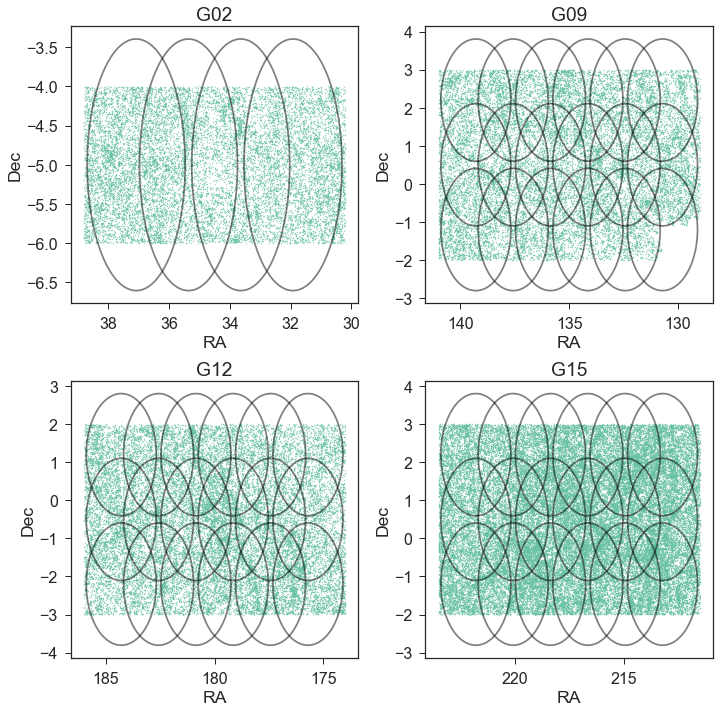

In [16]:
qa_gama_tiles(gama, tiles, overwrite=overwrite_tiles)

### Run survey simulations

Simulate SV observing.

One outstanding question is whether we need a new set of rules when calling *surveyplan* other than those in [desisurvey/data](https://github.com/desihub/desisurvey/tree/master/py/desisurvey/data).

Note that at the end we convert *progress.fits*, which is one row per tile, to *exposures.fits*, which has one row per exposure.

In [22]:
def survey_simulations(overwrite=False):
    """Run survey simulations.
    
    """
    if overwrite or not os.path.isfile(expfile):
        from desisurvey.progress import Progress
        from desisurvey.config import Configuration
        from surveysim.util import add_calibration_exposures
    
        Configuration.reset()
        config = Configuration(surveyconfigfile)

        survey_logname = os.path.join(surveydir, 'survey.log')
        print('Running survey simulations; logging to {}'.format(survey_logname))
        
        with open(survey_logname, 'w') as logfile:
            cmd = "surveyinit --config-file {} --output-path {}".format(surveyconfigfile, surveydir)
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            assert err == 0

            # Use 0d fiber assignment delay to move on with mini sim quickly
            # Do we need new rules?!?
            cmd = "surveyplan --config-file {} --output-path {} --create --fa-delay 0d".format(
                surveyconfigfile, surveydir)
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            assert err == 0

            cmd = "surveysim --config-file {} --output-path {} --seed {}".format(
                surveyconfigfile, surveydir, seed)
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            assert err == 0

            # Do we need new rules?!?
            plan_cmd = 'surveyplan --config-file {} --output-path {} --fa-delay 0d'.format(
                surveyconfigfile, surveydir)
            sim_cmd = 'surveysim --resume --config-file {} --output-path {} --seed {}'.format(
                surveyconfigfile, surveydir, seed)
            while True:
                lastdate = open(os.path.join(surveydir, 'last_date.txt')).readline().strip()
                progress = Table.read(os.path.join(surveydir, 'progress.fits'), 1)
                ndone = np.count_nonzero(progress['status'] == 2)
                print('Starting {} with {}/{} tiles completed {}'.format(lastdate, ndone, len(progress), time.asctime()))
                if subprocess.call(plan_cmd.split(), stdout=logfile, stderr=logfile) != 0:
                    break
                if subprocess.call(sim_cmd.split(), stdout=logfile, stderr=logfile) != 0:
                    break

        # Make sure observing truly finished.
        progressfile = os.path.join(surveydir, 'progress.fits')
        if not os.path.exists(progressfile):
            print("ERROR: Missing {}".format(progressfile))
            print("Check {} for what might have gone wrong".format(survey_logname))
    
        print('Files in {}:\n'.format(surveydir))
        !ls $surveydir
        
        # convert progress.fits -> exposures.fits
        p = Progress(restore='progress.fits')
        explist = p.get_exposures()
        explist = add_calibration_exposures(explist)

        # Sanity check that all tiles in the subset were observed in the exposures list.
        if not np.all(np.in1d(tiles['TILEID'], explist['TILEID'])):
            print("ERROR: some tiles weren't observed;\ncheck {} for failures".format(survey_logname) )
            print("Missing TILEIDs:", set(tiles['TILEID']) - set(explist['TILEID']))
        else:
            print('All tiles in the subset were observed at least once.')
            explist.write(expfile, overwrite=True)
            print('Writing {}'.format(expfile))                

        # Optionally make a movie
        if False:
            cmd = "surveymovie --config-file {} --output-path {}".format(
                surveyconfigfile, surveydir)
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            assert err == 0
    else:
        print('Simulated observing has been done.')
        explist = Table.read(expfile)
        print('Read {} exposures from {}'.format(len(explist), expfile))

    return explist

In [23]:
%time explist = survey_simulations(overwrite=overwrite_surveysim)

NameError: name 'surveyconfigfile' is not defined

In [ ]:
explist

### Visualize which healpixels cover the observed tiles.

In [ ]:
def tiles2pixels(nside=64):
    import desimodel.footprint
    pixels = desimodel.footprint.tiles2pix(nside, tiles)
    nexp = np.count_nonzero(np.in1d(explist['TILEID'], tiles['TILEID']))
    print('{} tiles covered by {} exposures and {} nside={} healpixels'.format(
        len(tiles), nexp, len(pixels), nside))
    return pixels

In [ ]:
def plot_healpix(nside, pixels, ax=None):
    '''Plot healpix boundaries; doesn't work at RA wraparound'''
    if ax is None:
        fig, ax = plt.subplots()
    for p in pixels:
        xyz = hp.boundaries(nside, p, nest=True)
        theta, phi = hp.vec2ang(xyz.T)
        theta = np.concatenate([theta, theta[0:1]])
        phi = np.concatenate([phi, phi[0:1]])
        ra, dec = np.degrees(phi), 90-np.degrees(theta)
        ax.plot(ra, dec, '-', color='0.6') 

In [ ]:
def qa_observed_tiles():
    isbright = explist['PROGRAM'] == 'BRIGHT'
    isgray = explist['PROGRAM'] == 'GRAY'
    isdark = explist['PROGRAM'] == 'DARK'
    
    fig, ax = plt.subplots()
    ax.plot(tiles['RA'], tiles['DEC'], 'k.', alpha=0.2, label='_none_')
    ax.plot(explist['RA'][isdark], explist['DEC'][isdark], 'o', color='k', ms=10, mew=2, label='dark')
    if np.sum(isgray) > 0:
        ax.plot(explist['RA'][isgray], explist['DEC'][isgray], 's', 
                color='0.6', ms=10, label='gray')
    if np.sum(isbright) > 0:
        ax.plot(explist['RA'][isbright], explist['DEC'][isbright], 'd', 
                color='m', ms=10, mew=2, label='bright')
    ax.legend(loc='upper right')
    #ax.set_xlim(148, 157)
    #ax.set_ylim(28, 37)

In [ ]:
def qa_tiles2pixels(nside=64):
    
    pixels = tiles2pixels(nside=nside)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    ax1.plot(tiles['RA'], tiles['DEC'], 'rx')
    ax1.plot(explist['RA'], explist['DEC'], 'b.', alpha=0.5)
    #xlim(0,360); ylim(-20, 80)

    plot_healpix(nside, pixels, ax=ax2)
    color = dict(DARK='k', GRAY='b', BRIGHT='m')
    for program in ['DARK', 'GRAY', 'BRIGHT']:
        ii = tiles['PROGRAM'] == program
        ax2.plot(tiles['RA'][ii], tiles['DEC'][ii], '.', color=color[program], alpha=0.5)
        jj = tiles['PROGRAM'] == program
        for t in tiles[jj]:
            plot_tile(t['RA'], t['DEC'], color=color[program])
    #xlim(143, 161); ylim(28, 37)
    
    return pixels

In [ ]:
pixels = qa_tiles2pixels()

In [ ]:
pixels